# Paneling MPAS forecasts

In [1]:
import xarray as xr
import numpy as np
from datetime import datetime
from datetime import timedelta
from os.path import exists

# trick to read function in a separate file
import sys
sys.path.append('/glade/u/home/rberrios/python/PRECIP/')
from defineColormaps import *

# for smoothing out contours
import scipy as sp
import scipy.ndimage

# for calculating saturated vapor mixing ratio
sys.path.append('/glade/u/home/rberrios/projects/ASD2022-2023/')
from functions_mpas import RSLF

In [25]:
# Define dictionary with vars info.
plottingInfo = {
    'precipw': {'levels':np.arange(10,70,2),'units':'mm','longName':'precipitable water vapor (mm)','cmap':defineColormap('precipw'),'ifsName':'TCIWV_P0_2L1_8_GLL0','gfsName':'PWAT_P0_L200_GLL0'},
    'wspd': {'levels':np.arange(1,26,1),'units':'m s$^{-1}$','longName':'10-m Winds (m/s) and MSLP (mb)','cmap':defineColormap('wspd')},
    'mslp': {'levels':np.arange(980,1020,2),'units':'mb','longName':'10-m Winds (m/s) and MSLP (mb)','fmt':'%4.4i','gfsName':'PRMSL_P0_L101_GLL0','ifsName':'PRES_P0_L101_GLL0'},
    'refl10cm_1km': {'levels':np.arange(5,80,5),'units':'dBZ','longName':'Reflectivity at 1 km AGL (dBZ)','cmap':defineColormap('refl10cm_1km')},
    'refl10cmComp': {'levels':np.arange(5,80,5),'units':'dBZ','longName':'Composite reflectivity (dBZ)','cmap':defineColormap('refl10cm_1km'),'gfsName':'REFC_P0_L10_GLL0'},
    'acpc24': {'levels':[0.1,1,2,6,10,15,20,30,40,50,70,90,110,130,150,200,300],'units':'mm','longName': 'Accumulated rainfall over the past 24 h','cmap':defineColormap('acpc')},
    'acpc12': {'levels':[0.1,1,2,6,10,15,20,30,40,50,70,90,110,130,150,200,300],'units':'mm','longName': 'Accumulated rainfall over the past 12 h','cmap':defineColormap('acpc')},
    'acpc6': {'levels':[0.1,1,2,6,10,15,20,30,40,50,70,90,110,130,150,200,300],'units':'mm','longName': 'Accumulated rainfall over the past 6 h','cmap':defineColormap('acpc')},
    'acpc1': {'levels':[0.1,1,2,6,10,15,20,30,40,50,70,90,110,130,150,200,300],'units':'mm','longName': 'Accumulated rainfall over the past 1 h','cmap':defineColormap('acpc')},
    # 'rainr': {'levels':[0.0,0.1,0.2,0.3,0.4,0.5,0.75,1.0,1.5,2.0,2.5,3.5,4.0,5.0,6.0,8.0,10.0],'units':'mm h$^{-1}$','longName': 'Rainfall rate (mm/hr)','cmap':defineColormap('rainr'),'gfsName':'PRATE_P0_L1_GLL0'},
    'rainr': {'levels':[0.0,0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0,3.0,4.0,5.0,10.0,15.0,20.0],'units':'mm h$^{-1}$','longName': 'rainfall rate','cmap':defineColormap('rainr'),'gfsName':'PRATE_P0_L1_GLL0'},
    'ivt': {'levels': [250,300,400,500,600,700,800,1000,1200,1400,1800],'units':'kg m$^{-1}$s$^{-1}$','longName':'Integrated vapor transport (100-1000 mb)','cmap':'CMRmap_r'},
    'cape': {'levels':np.arange(100,5000,100),'units':'J kg$^{-1}$','longName':'Convective Available Potential Energy','cmap':'cubehelix_r','gfsName':'CAPE_P0_L1_GLL0'},
    'cin': {'levels':np.arange(10,500,10),'units':'J kg$^{-1}$','longName':'Convective inhibition','cmap':'gist_stern_r','gfsName':'CIN_P0_L1_GLL0'},
    'shear': {'levels':np.arange(2.5,52.5,2.5),'units':'m s$^{-1}$','longName':'200-850 mb shear','cmap':'tab20c_r'},
    'olrtoa': {'levels':np.arange(170,270,1),'units':'W m$^{-2}$','longName':'TOA outgoing longwave radiation','cmap':'Greys','gfsName':'ULWRF_P8_L8_GLL0_avg3h'},
    '200mb_rh' : {'levels':np.arange(0,105,5),'units':'%','longName': 'Rel. hum., heights, and winds at 200 mb' ,'cmap':'RdYlGn','gfsName':'RH_P0_L100_GLL0'},
    '500mb_rh' : {'levels':np.arange(0,105,5),'units':'%','longName': 'Rel. hum., heights, and winds at 500 mb' ,'cmap':'RdYlGn','gfsName':'RH_P0_L100_GLL0'},
    '700mb_rh' : {'levels':np.arange(0,105,5),'units':'%','longName': 'Rel. hum., heights, and winds at 700 mb' ,'cmap':'RdYlGn','gfsName':'RH_P0_L100_GLL0'},
    '850mb_rh' : {'levels':np.arange(0,105,5),'units':'%','longName': 'Rel. hum., heights, and winds at 850 mb' ,'cmap':'RdYlGn','gfsName':'RH_P0_L100_GLL0'},
    '200mb_z' : {'levels':np.arange(1200,1304,4),'fmt':'%4.4i'},
    '500mb_z' : {'levels':np.arange(500,604,4),'fmt':'%3.3i'},
    '700mb_z' : {'levels':np.arange(290,320,2),'fmt':'%3.3i'},
    '850mb_z' : {'levels':np.arange(140,160,2),'fmt':'%3.3i'},
    '200mb_wind' : {'levels':np.arange(30,190,10),'units':'kts','longName':'Winds at 200 mb and MSLP','cmap':defineColormap('isobaricWindSpeed')},
    '600mb_wind' : {'levels':np.arange(15,65,5),'units':'kts','longName':'Winds at 600 mb and MSLP','cmap':defineColormap('wspd')},
    '850mb_wind' : {'levels':np.arange(15,65,5),'units':'kts','longName':'Winds at 850 mb and MSLP','cmap':defineColormap('wspd')},
    '925mb_wind' : {'levels':np.arange(5,50,5),'units':'kts','longName':'Winds at 925 mb and MSLP','cmap':defineColormap('wspd')},
    '200mb_vorticity' : {'levels':[-6,-4,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,4,6,8,9,10,12,14,16,18,20,25,30,35,40],'units':'10$^{-5}$ s$^{-1}$','longName':'Vorticity, heights, and winds at 200 mb','cmap':defineColormap('vorticity')},
    '500mb_vorticity' : {'levels':[-6,-4,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,4,6,8,9,10,12,14,16,18,20,25,30,35,40],'units':'10$^{-5}$ s$^{-1}$','longName':'Vorticity, heights, and winds at 500 mb','cmap':defineColormap('vorticity')},
    '850mb_vorticity' : {'levels':[-6,-4,-2,-1.5,-1.0,-0.5,0,0.5,1,1.5,2,4,6,8,9,10,12,14,16,18,20,25,30,35,40],'units':'10$^{-5}$ s$^{-1}$','longName':'Vorticity, heights, and winds at 850 mb','cmap':defineColormap('vorticity')},
    '925mb_eth' : {'levels':np.arange(330,362,2),'units':'K','longName': 'Equiv. Pot. Temp. and Frontogenesis at 925 mb' ,'cmap':defineColormap('t2m'),'gfsName':'','ifsName':''},
    'sfcThetaGrad': {'levels':[2.5,5.0,7.5,10.0],'units':'10$^{-5}$ K m$^{-1}$','longName':'surface $\\nabla\\theta$ (colors) and $\\theta$','cmap':'hot_r'},
    'th2m': {'levels':np.arange(280,311,0.5),'units':'K','longName':'2-m potential temperature','cmap':defineColormap('t2m'),'fmt':'%3.3i','ifsName':''},
    't2m': {'levels':np.arange(-40.0,40.5,0.5),'units':'$^{\circ}$C','longName':'2-m temperature and 10-m winds','cmap':defineColormap('t2m'),'gfsName':'','ifsName':'TMP_P0_L103_GLL0'},
    'td2m': {'levels':np.arange(1.0,27.0,1.0),'units':'$^{\circ}$C','longName':'2-m dew point temp. and 10-m winds','cmap':'rainbow'},
    'brightnessT':{'levels':np.arange(170,378,1),'units':'K','longName':'Simulated brightness temp.','cmap':defineColormap('IR')},
    'frontogenesis':{'levels':[0.1,0.5,1.0,1.5,2.0],'units':'','longName':'Frontogenesis at 925 mb','cmap':'Blues','fmt':'%2.2f','gfsName':'frontogenesis'},
    'rainMorphology':{'levels':[-0.5,0.5,1.5,2.5,3.5],'units':'type','longName': 'Convective, stratiform, and anvil class.','cmap':defineColormap('rainMorphology')},
    '950mb_qv':{'levels':np.arange(14.0,19.0,0.1),'units':'g kg$^{-1}$','longName': '950-mb water vapor mixing ratio & wind','cmap':'YlGnBu'},
    '650mb_wind' : {'levels':np.arange(15,65,5),'units':'kts','longName':'Winds at 650 mb and MSLP','cmap':defineColormap('wspd'),'fmt':'%3.3i'},
    '650mb_zonal_wind' : {'levels':np.arange(-30,-5,5),'units':'kts','longName':'Winds at 650 mb and MSLP','cmap':defineColormap('wspd'),'fmt':'%3.3i'},
    'thrho': {'levels':np.arange(280,311,0.5),'units':'K','longName':r'near-surface $\theta_{\rho}$','cmap':defineColormap('t2m'),'fmt':'%2.3i','ifsName':''},
}

In [80]:
def read_mpas_latlon_realtime(TODAY,fhr,outputDir,minLat,maxLat,minLon,maxLon,mainVar,**kwargs):
    def get_dew_point_c(t_air_c, rel_humidity):
        """Compute the dew point in degrees Celsius
        :param t_air_c: current ambient temperature in degrees Celsius
        :type t_air_c: float
        :param rel_humidity: relative humidity in fraction
        :type rel_humidity: float
        :return: the dew point in degrees Celsius
        :rtype: float
        """
        A = 17.27
        B = 237.7
        alpha = ((A * (t_air_c)) / (B + (t_air_c))) + np.log(rel_humidity)
        return (B * alpha) / (A - alpha)
    
    variablesInfo = {
        'level': 0.0,
        'winds': False,
        'secondVar' : False,
        'accumPeriod': 1,
        'mpasStr':'wpac',
    }

    print(outputDir)
    
    for keys in kwargs:
        variablesInfo[keys] = kwargs[keys]
        
    mpasStr = variablesInfo['mpasStr']
    
    out = {}
    
    # define constants
    REarth = 6378.1e3
        
    #read file name as a dataset
    validTimeFormatted=datetime.strftime(datetime.strptime(TODAY+HH, '%Y%m%d%H')+timedelta(hours=(fhr)), '%Y-%m-%d_%H:%M')
    fname='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeFormatted,mpasStr)
    print(fname)
    ds = xr.open_dataset(fname).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon)).squeeze()
    if (mainVar == 'wspd'):
        field1 = (ds.u10**2.0 + ds.v10**2.0)**0.5
    elif (mainVar == 'acpc'):
        totalRain = ds.rainnc+ds.rainc
        if (fhr-variablesInfo['accumPeriod'] < 0):
            #dummy variable having all zeroes
            field1 = totalRain*0.0
        else:
            validTimeMinusT = datetime.strftime(datetime.strptime(TODAY+HH, '%Y%m%d%H')+timedelta(hours=int(fhr))-timedelta(hours=int(variablesInfo['accumPeriod'])), '%Y-%m-%d_%H:%M')
            fname2 = '%smpas_init_%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY+HH,validTimeMinusT,mpasStr)
            ds2 = xr.open_dataset(fname2).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon)).squeeze()
            totalRainMinusT = ds2.rainnc+ds2.rainc
            del(ds2)
            field1 = totalRain-totalRainMinusT
    elif (mainVar == 'rainr'):
        totalRain = ds.rainnc+ds.rainc
        # assumed to be hourly rain rate
        h2 = np.max([fhr-1,0])
        h1 = fhr
        if (h1 != h2):
            # validTimeMinusT = datetime.strftime(datetime.strptime(TODAY+HH, '%Y%m%d%H')+timedelta(hours=int(h2)), '%Y-%m-%d_%H')
            # fname2 = '%smpas_init_%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY+HH,validTimeMinusT,mpasStr)
            validTimeMinusT=datetime.strftime(datetime.strptime(TODAY+HH, '%Y%m%d%H')+timedelta(hours=int(h2)), '%Y-%m-%d_%H:%M')
            fname2='%smpas_init_%s%s_valid_%s_latlon_%s.nc'%(outputDir,TODAY,HH,validTimeMinusT,mpasStr)
            print(fname2)
            ds2 = xr.open_dataset(fname2).sel(latitude=slice(minLat,maxLat),longitude=slice(minLon,maxLon)).squeeze()
            totalRainMinusT = ds2.rainnc+ds2.rainc
            field1 = (totalRain-totalRainMinusT)/(h1-h2)
        else:
            field1 = totalRain*0.0
    elif (mainVar == 'ivt'):
        ivtu = ds.ivtu
        ivtv = ds.ivtv
        field1 = (ivtu**2.0+ivtv**2.0)**0.5
        out['uwind']=ivtu
        out['vwind']=ivtv
    elif (mainVar == 'shear'):
        ushr = ds.uzonal_isobaric.sel(u_iso_levels=20000)-ds.uzonal_isobaric.sel(u_iso_levels=85000)
        vshr = ds.umeridional_isobaric.sel(u_iso_levels=20000)-ds.umeridional_isobaric.sel(u_iso_levels=85000)
        field1 = (ushr**2.0+vshr**2.0)**0.5
        out['uwind']=ushr
        out['vwind']=vshr
    elif ('_rh' in mainVar):
        field1 = ds['rh_isobaric'].sel(t_iso_levels=variablesInfo['level'])
    elif ('isobaricWindSpeed' in mainVar):
        field1 = (ds.uzonal_isobaric.sel(u_iso_levels=variablesInfo['level'])**2.0+
                  ds.umeridional_isobaric.sel(u_iso_levels=variablesInfo['level'])**2.0)**0.5
    elif (mainVar == 'sfcThetaGrad'):
        #compute theta at 2 m
        t2m = ds.t2m
        mslp = ds.mslp
        theta = t2m*(100000.0/mslp)**(287.15/1004.0)
        #compute the gradient of theta
        theta_x = xr.DataArray(np.gradient(theta,np.radians(theta.lon)*REarth,axis=1),coords=theta.coords,dims=theta.dims)
        theta_y = xr.DataArray(np.gradient(theta,np.radians(theta.lat)*REarth,axis=0),coords=theta.coords,dims=theta.dims)
        field1 = (theta_x**2.0+theta_y**2.0)**0.5
        out['th2m']=theta
    elif (mainVar == 'th2m'):
        #compute theta at 2 m
        t2m = ds.t2m
        mslp = ds.mslp
        field1 = t2m*(100000.0/mslp)**(287.15/1004.0)
    elif (mainVar == 'td2m'):
        #calculate dew point
        #we need rh at 2 m
        t2m = ds.t2m
        q2m = ds.q2
        prs = ds.mslp
        
        #calculate qvs
        #first we need saturated vapor pressure
        es=611.0*np.exp( (17.27*(t2m-273.15))/(237.3+(t2m-273.15)) )
        #now calculate qvs
        qvs = 0.622*((es)/(prs-es))
        #we have rh
        rh2 = q2m/qvs
        #now we can call the function to calculate Td from T and RH
        field1 = get_dew_point_c(t2m-273.15, rh2)+273.15 #return in K
    elif ('qv' in mainVar):
        #equivalent potential temp following Bolton
        temperature = ds['t_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        rh = ds['rh_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        # need to calculate qv from T and RH        
        # calculate es
        es=(611.0*np.exp( (17.27*(temperature-273.15))/(237.3+(temperature-273.15)) ))
        # calculate qvs
        qvs = (0.622*((es)/(variablesInfo['level']-es)) )
        field1 = (rh/100.)*qvs*1000.0
        del(qvs,rh)
    elif (mainVar == 'thrho'):
        # density potential temperature to identify cold pools
        theta = ds['theta'].isel(nVertLevels=0)
        qv = ds['qv'].isel(nVertLevels=0)
        qc = ds['qc'].isel(nVertLevels=0)
        qr = ds['qr'].isel(nVertLevels=0)
        field1 = theta*(1.0 + (0.608*qv) - qc - qr)        
    elif ('eth' in mainVar):
        # print('this is wrong!!! fix!!!')
        # #equivalent potential temp following Bolton
        # temperature = ds['t_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        # rh = ds['rh_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        # # need to calculate qv from T and RH        
        # # calculate es
        # es=(611.0*np.exp( (17.27*(temperature-273.15))/(237.3+(temperature-273.15)) ))
        # # es should be in mb
        # es = es*0.01
        # # calculate qvs
        # qvs = (0.622*((es)/(variablesInfo['level']*0.01-es)) )
        # qv = (rh/100.)*qvs
        # del(qvs,rh)
        # #calculate theta
        # th = temperature*(100000.0/variablesInfo['level'])**(287.15/1004.0)
        # #calculate Tl
        # tl = (2840.0)/(3.5*np.log(temperature)-np.log(es)-4.805) + 55.0
        # #final calculation
        # field1 = (th*np.exp( (3.376/tl - 0.00254)*qv*1.0e3*(1.0+0.81*qv)  ))
        # del(temperature,qv,es,th,tl)
        # pseudoadiabatic theta-e
        temperature = temperature = ds['t_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        rh = ds['rh_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        pressure = variablesInfo['level']
        QVPS = RSLF(pressure, temperature)
        qv = rh*0.01*QVPS
        print(qv.min().values, qv.max().values)
        ETH=temperature*( (100000.0/pressure)**(0.2854*(1.0-0.28*qv)) )   \
               *np.exp( ((3376.0/temperature)-2.54)*qv*(1.0+0.81*qv) ) 
        field1 = ETH
    elif (mainVar == 'refl10cmComp'):
        field1 = ds['refl10cm'].max(dim='nVertLevels')
    elif (mainVar == 'brightnessT'):
        # simple Stefan-Boltzmann
        # sigma=5.67e-8
        # field1 = (ds['olrtoa']/sigma)**0.25
        # linear relationship following Vaillant De Guélis et al. (2017)
        a = 2.0
        b = -310.0
        field1 = (ds['olrtoa']-b)/a
    elif ('frontogenesis' in mainVar):
        temperature = ds.t_isobaric.sel(t_iso_levels=variablesInfo['level'])
        th = temperature*(100000.0/variablesInfo['level'])**(287.15/1004.0)
        rh = ds['rh_isobaric'].sel(t_iso_levels=variablesInfo['level'])
        # need to calculate qv from T and RH        
        # calculate es
        es=(611.0*np.exp( (17.27*(temperature-273.15))/(237.3+(temperature-273.15)) ))
        # calculate qvs
        qvs = (0.622*((es)/(variablesInfo['level']-es)) )
        qv = (rh/100.)*qvs
        del(temperature,rh,qvs,es)
        thv = th*(1.0+0.61*qv)
        del(qv)
        uwind = ds.uzonal_isobaric.sel(u_iso_levels=variablesInfo['level'])
        vwind = ds.umeridional_isobaric.sel(u_iso_levels=variablesInfo['level'])
        
        # zero out where there is high terrain
        z1000 = ds['z_isobaric'].sel(z_iso_levels=100000)
        thv = thv.where(z1000 <= 500.0)
        
        #calculate gradient
        u_grad_p = np.gradient(uwind,np.radians(thv.latitude)*REarth,np.radians(thv.longitude)*REarth)
        v_grad_p = np.gradient(vwind,np.radians(thv.latitude)*REarth,np.radians(thv.longitude)*REarth)
        thv_p_grad = np.gradient(thv,np.radians(thv.latitude)*REarth,np.radians(thv.longitude)*REarth)
        # actual calculation
        thv_p_mag = np.sqrt(thv_p_grad[0]**2 + thv_p_grad[1]**2)
        F = -(1/thv_p_mag)*((thv_p_grad[1]**2)*u_grad_p[1] + (thv_p_grad[0]**2)*v_grad_p[0] + thv_p_grad[0]*thv_p_grad[1]*(v_grad_p[1] + u_grad_p[0]))
            
        # smooth out
        sigma=2.0
        F = sp.ndimage.filters.gaussian_filter(F, sigma)        
        
        fig=plt.figure()
        plt.contourf(F)   
        plt.colorbar()
        display(fig)
        
        field1 = xr.DataArray(F*1.0e9,coords=thv.coords,dims=thv.dims)
        del(F,u_grad_p,v_grad_p,thv_p_grad,thv_p_mag)
    else:
        field1 = ds[mainVar]
        
    out[mainVar] = field1
    
    # read second field if requested
    if (variablesInfo['secondVar'] != False):
        
        if (variablesInfo['secondVar']=='mslp'):
            field2 = ds[variablesInfo['secondVar']]
        else:
            if (variablesInfo['secondVar'] == 'z_isobaric'):
                field2 = ds[variablesInfo['secondVar']].sel(z_iso_levels=variablesInfo['level'])
            elif (variablesInfo['secondVar'] == '650mb_zonal_wind'):
                field2 = ds['uzonal_isobaric'].sel(u_iso_levels=65000.0)
            elif ('frontogenesis' in variablesInfo['secondVar']):
                temperature = ds.t_isobaric.sel(t_iso_levels=variablesInfo['level'])
                th = temperature*(100000.0/variablesInfo['level'])**(287.15/1004.0)
                rh = ds['rh_isobaric'].sel(t_iso_levels=variablesInfo['level'])
                # need to calculate qv from T and RH        
                # calculate es
                es=(611.0*np.exp( (17.27*(temperature-273.15))/(237.3+(temperature-273.15)) ))
                # calculate qvs
                qvs = (0.622*((es)/(variablesInfo['level']-es)) )
                qv = (rh/100.)*qvs
                del(temperature,rh,qvs,es)
                thv = th*(1.0+0.61*qv)
                del(qv)
                uwind = ds.uzonal_isobaric.sel(u_iso_levels=variablesInfo['level'])
                vwind = ds.umeridional_isobaric.sel(u_iso_levels=variablesInfo['level'])

                # # zero out where there is high terrain
                # z1000 = ds['z_isobaric'].sel(z_iso_levels=100000)
                # thv = thv.where(z1000 <= 500.0)

                #calculate gradient
                u_grad_p = np.gradient(uwind,np.radians(thv.latitude)*REarth,np.radians(thv.longitude)*REarth)
                v_grad_p = np.gradient(vwind,np.radians(thv.latitude)*REarth,np.radians(thv.longitude)*REarth)
                thv_p_grad = np.gradient(thv,np.radians(thv.latitude)*REarth,np.radians(thv.longitude)*REarth)
                # actual calculation
                thv_p_mag = np.sqrt(thv_p_grad[0]**2 + thv_p_grad[1]**2)
                F = -(1/thv_p_mag)*((thv_p_grad[1]**2)*u_grad_p[1] + (thv_p_grad[0]**2)*v_grad_p[0] + thv_p_grad[0]*thv_p_grad[1]*(v_grad_p[1] + u_grad_p[0]))

                # smooth out
                sigma=5.0
                F = sp.ndimage.filters.gaussian_filter(F, sigma)        

                field2 = xr.DataArray(F*1.0e9,coords=thv.coords,dims=thv.dims)
                del(F,u_grad_p,v_grad_p,thv_p_grad,thv_p_mag)
            else:
                print('wrong variable')

        # commented out bc RRB changed the output and we no longer have z_isobaric
        # #zero out field 2 where there is high terrain
        # if (variablesInfo['level']>= 85000) | (variablesInfo['level']== 0.0) | (variablesInfo['secondVar']=='mslp'):
        #     z1000 = ds['z_isobaric'].sel(z_iso_levels=100000)
        #     field2 = field2.where(z1000 <= 1000.0)
        
        out[variablesInfo['secondVar']] = field2
        
    #read winds if requested
    if variablesInfo['winds']:
        if (variablesInfo['level'] == 0.0):
            uwind = ds.u10
            vwind = ds.v10
        else:
            uwind = ds.uzonal_isobaric.sel(u_iso_levels=variablesInfo['level'])
            vwind = ds.umeridional_isobaric.sel(u_iso_levels=variablesInfo['level'])
        
        out['uwind']=uwind
        out['vwind']=vwind
        
        
    #we're all done reading output
    return out

In [82]:
def read_model_output_realtime(model,TODAY,fhr,outputDir,minLat,maxLat,minLon,maxLon,mainVar,**kwargs):
    
    variablesInfo = {
        'level': 0.0,
        'winds': False,
        'secondVar' : False,
        'accumPeriod': 1,
    }
    
    domainsInfo = {'wpac':'wpac','Taiwan':'Taiwan','ZoomTaiwan':'Taiwan',
                   'conus':'atl','atl':'atl','westAfrica':'westAfrica',
                   'hurrSAM':'atl',
                  'southAmerica':'sam','global':'global',
                  'TAHPEX':'Taiwan'}
    
    for keys in kwargs:
        variablesInfo[keys] = kwargs[keys] 
        
    if (model == 'mpas'):
        out = read_mpas_latlon_realtime(TODAY,fhr,outputDir,minLat,maxLat,minLon,maxLon,mainVar,
                                        level=variablesInfo['level'],winds=variablesInfo['winds'],
                               secondVar=variablesInfo['secondVar'],accumPeriod=variablesInfo['accumPeriod'],
                                       mpasStr=domainsInfo[domain])
    elif (model == 'gfs'):
        out = read_gfs_realtime(TODAY,fhr,minLat,maxLat,minLon,maxLon,mainVar,
                                level=variablesInfo['level'],winds=variablesInfo['winds'],
                               secondVar=variablesInfo['secondVar'],accumPeriod=variablesInfo['accumPeriod'])
    elif (model == 'ifs'):
        out = read_ifs_realtime(TODAY,fhr,minLat,maxLat,minLon,maxLon,mainVar,
                                level=variablesInfo['level'],winds=variablesInfo['winds'],
                               secondVar=variablesInfo['secondVar'],accumPeriod=variablesInfo['accumPeriod'])
    elif (model == 'era5'):
        out = read_era5_archive(TODAY,fhr,minLat,maxLat,minLon,maxLon,mainVar,
                                level=variablesInfo['level'],winds=variablesInfo['winds'],
                                secondVar=variablesInfo['secondVar'],accumPeriod=variablesInfo['accumPeriod'])        
    else:
        print('WRONG MODEL')
        
    return out

In [112]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from IPython.display import display
from datetime import datetime, timedelta
import numpy as np
import scipy as sp # Needed for the smoothing filter used in original code
%matplotlib inline
# increase font size
plt.rcParams.update({"font.size": 16})

def plot_6panel_maps(model, mainVar, domain, initTime):
    
    # --- 1. Setup Times and Initialization ---
    
    # We want 6 panels, every 6 hours: [0, 6, 12, 18, 24, 30]
    forecast_hours = [24, 30, 36, 42, 48, 54] 
    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

    # --- 2. Define Domain Boundaries (Moved outside loop) ---
    plotSecondVar = False
    plotWinds = False
    ms2kts = 1.94384
    landColor = 'k'
    
    # Default projection settings
    centerLon = 0
    
    if domain == "wpac":
        minLat, maxLat = -10, 50.01
        minLon, maxLon = 80, 180.0
        lat_interval, lon_interval = 10, 15
        inc = 25 if model == 'mpas' else (10 if model == 'gfs' else 5)
        length, lw = 3, 0.75
    elif domain == "Taiwan":
        minLat, maxLat = 9, 35.01
        minLon, maxLon = 106, 138.01
        lat_interval, lon_interval = 5, 5
        inc = 10 if model == 'mpas' else 5
        length, lw = 3, 1.5
    elif domain == "ZoomTaiwan":
        minLat, maxLat = 21, 26.5
        minLon, maxLon = 119, 125.01
        lat_interval, lon_interval = 1, 1
        inc = 2 if model == 'mpas' else 1
        length, lw = 3, 1.5
    elif domain == "atl":
        minLat, maxLat = -10.0, 50.01
        minLon, maxLon = -105.0, 15.0
        lat_interval, lon_interval = 10, 15
        inc = 25 if model == 'mpas' else (10 if model == 'gfs' else 5)
        length, lw = 3, 0.75
    elif domain == 'conus':
        minLat, maxLat = 20.0, 55.0
        minLon, maxLon = -130.0, -65.0
        lat_interval, lon_interval = 5, 15
        inc = 15 if model == 'mpas' else 5
        length, lw = 3, 1.5
    elif (domain == "westAfrica"):
        minLat, maxLat = 3.0, 18.0
        minLon, maxLon = -25.0, -2.0
        lat_interval, lon_interval = 5, 5
        inc = 40 if model == 'mpas' else 5
        length, lw = 5, 2.5
        mpasStr='atl'
    # ... (Add other domains from original code here if needed) ...
    else:
        # Fallback default
        minLat, maxLat = 0, 50
        minLon, maxLon = 100, 180
        lat_interval, lon_interval = 10, 10
        inc, length, lw = 5, 3, 1.0

    # --- 3. Setup Figure and Axes ---
    projection = ccrs.PlateCarree(central_longitude=centerLon)
    
    # Create 6 subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), 
                             subplot_kw={'projection': projection})

    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.15, 
                            wspace=0.1, hspace=0.01)

    # Flatten axes array for easy looping
    axes_flat = axes.flatten()
    
    # Variable to store the contour plot for the shared colorbar later
    last_plot_handle = None

    # --- 4. Main Loop Over Times ---
    for i, fhr in enumerate(forecast_hours):
        ax = axes_flat[i]
        current_dt = initTime + timedelta(hours=fhr)
        validTimeFormatted = current_dt.strftime('%Y-%m-%d_%H:%M')
        prettyDate = current_dt.strftime('%H00 UTC %d %b') # e.g., 1200 UTC 13 Sep
        
        print(f"Processing panel {panel_labels[i]}: fhr {fhr} ({validTimeFormatted})")

        # --- Data Loading Logic (Preserved from original) ---
        # Note: This assumes 'read_model_output_realtime' is available in your scope
        # and 'plottingInfo' dict is available.
        
        # Reset flags for each loop
        plotSecondVar = False
        plotWinds = False
        
        if (mainVar == 'wspd'):
            secondVar = 'mslp'
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar, secondVar=secondVar, winds=True)
            field1 = out[mainVar]
            field2 = out[secondVar]*0.01
            uwind, vwind = out['uwind'], out['vwind']
            plotSecondVar = True
            plotWinds = True
        elif (mainVar == 'ivt'):
            secondVar = 'mslp'
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar, secondVar=secondVar)
            field1 = out['ivt']
            field2 = out['mslp']*0.01
            uwind, vwind = out['uwind'], out['vwind']
            plotSecondVar = True
            plotWinds = True
            field1 = field1.where(field1>250)
            uwind = uwind.where(field1>250)
            vwind = vwind.where(field1>250)
        elif (mainVar == 'refl10cm_1km') | (mainVar == 'rainr'):
            secondVar = '650mb_zonal_wind'
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar, winds=True)
            field1 = out[mainVar]
            uwind = out['uwind']*ms2kts
            vwind = out['vwind']*ms2kts
            plotWinds=True
            plotSecondVar=False
        elif ('_rh' in mainVar):
            level = int(mainVar[0:3])
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, 'rh_isobaric', level=level*100, secondVar='z_isobaric', winds=True)
            field1 = out['rh_isobaric']
            field2 = out['z_isobaric']*0.1
            uwind, vwind = out['uwind']*ms2kts, out['vwind']*ms2kts
            plotSecondVar = True
            secondVar = '%smb_z'%mainVar[0:3]
            plotWinds = True
        # ... (Include other elif blocks from your original code as needed) ...
        else:
             # Generic Fallback
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar)
            field1 = out[mainVar]

        # Grid setup
        if (model=='mpas') | (model=='era5'):
            lons, lats = np.meshgrid(field1.longitude, field1.latitude)
        else:
            lons, lats = np.meshgrid(field1.lon_0, field1.lat_0)

        # --- Plotting on the current Axis (ax) ---
        ax.set_extent([minLon, maxLon, minLat, maxLat], crs=projection)
        
        # Ticks: Only Left edge and Bottom edge
        # Determine Row and Column
        row = i // 3  # 0 = Top (Exp1), 1 = Bottom (Exp2)
        col = i % 3   # 0, 1, 2 corresponding to the 3 times
        if col == 0:
            ax.set_yticks(np.arange(minLat, maxLat+0.1, lat_interval), crs=projection)
            ax.yaxis.set_major_formatter(LatitudeFormatter())
            
            # Add ROW LABEL (Experiment Name) on the far left
            # We use axes coordinates. x=-0.25 puts it to the left of the y-axis ticks
            # ax.text(-0.25, 0.5, current_model, transform=ax.transAxes, 
            #         rotation=90, va='center', ha='center', fontsize=14, fontweight='bold')
        else:
            ax.set_yticks([])
            
        if row == 1:
            ax.set_xticks(np.arange(minLon, maxLon+0.1, lon_interval), crs=projection)
            ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        else:
            ax.set_xticks([])
        
        # Features
        if (mainVar == 'olrtoa'): landColor = 'cyan'
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), alpha=0.5, edgecolor=landColor) # Changed to 50m for speed
        ax.add_feature(cfeature.BORDERS, alpha=0.4, edgecolor=landColor)
        if domain == 'conus':
            ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines','110m',alpha=0.4, facecolor='none'))

        # Contour/Pcolor Plot
        cnLevels = plottingInfo[mainVar]['levels']
        cmap = plottingInfo[mainVar]['cmap']
        
        # Logic for Normalize vs Standard
        if ('acpc' in mainVar) | (mainVar == 'rainr') | ('vorticity' in mainVar):
            norm = mcolors.BoundaryNorm(boundaries=cnLevels, ncolors=len(cnLevels)-1)
            plotCnt = ax.contourf(lons, lats, field1, transform=projection, levels=cnLevels, extend='both', cmap=cmap, norm=norm)
        else:
            plotCnt = ax.contourf(lons, lats, field1, transform=projection, levels=cnLevels, extend='both', cmap=cmap)
            
        # Save the plot handle for the colorbar later
        last_plot_handle = plotCnt
        
        # Second Variable (Lines)
        if plotSecondVar:
            sigma=2.0
            # assuming sp (scipy) is imported
            field2_smooth = sp.ndimage.filters.gaussian_filter(field2, sigma)
            cnLevels2 = plottingInfo[secondVar]['levels']
            plotCntLines = ax.contour(lons, lats, field2_smooth, transform=projection, colors='k', levels=cnLevels2, linewidths=lw)
            ax.clabel(plotCntLines, inline=1, fontsize=6, fmt=plottingInfo[secondVar]['fmt'])

        # Winds
        if plotWinds:
            # Subsample grid for vectors/barbs
            sl_x = slice(None, None, inc)
            sl_y = slice(None, None, inc)
            
            if (mainVar == 'wspd') | (mainVar == 'ivt') | (mainVar == 'shear'):
                ax.quiver(lons[sl_y, sl_x], lats[sl_y, sl_x], uwind[sl_y, sl_x], vwind[sl_y, sl_x], transform=projection)
            else:
                ax.barbs(lons[sl_y, sl_x], lats[sl_y, sl_x], uwind[sl_y, sl_x], vwind[sl_y, sl_x], 
                         length=length, lw=0.5, transform=projection)

        # --- Panel labels ---
        ax.text(0.02, 0.975, f"{panel_labels[i]} {prettyDate}", 
                transform=ax.transAxes, fontsize=18, fontweight='bold', va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5))

# --- 5. Add Manual Colorbar (The Fix) ---
    
    # We define a new axis [left, bottom, width, height] in figure coordinates (0 to 1)
    # height=0.02 is 2% of the figure height (Very thin)
    # bottom=0.05 puts it near the bottom edge
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02]) 
    
    # We pass 'cax=cbar_ax' to tell matplotlib "Draw the bar exactly HERE"
    cbar = fig.colorbar(last_plot_handle, cax=cbar_ax, orientation='horizontal')
    
    cbar.ax.set_xlabel(f"{plottingInfo[mainVar]['longName']} [{plottingInfo[mainVar]['units']}]", fontsize=18)
    
    # --- 6. Save Figure ---
    fout = f"6panel_{model}_{mainVar}_{domain}_12Z13Sep.jpg"
    plt.savefig(fout, bbox_inches='tight', dpi=200)
    # plt.show()
    print(f'Created 6-panel plot: {fout}')

Processing panel (a): fhr 24 (2022-09-13_12:00)
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_12:00_latlon_westAfrica.nc
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_11:00_latlon_westAfrica.nc
Processing panel (b): fhr 30 (2022-09-13_18:00)
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_18:00_latlon_westAfrica.nc
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld/intrp_output/mpas_init_2022091212_valid_2022-09-13_17:00_latlon_westAfrica.nc
Processing panel (c): fhr 36 (2022-09-14_00:00)
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/202209121

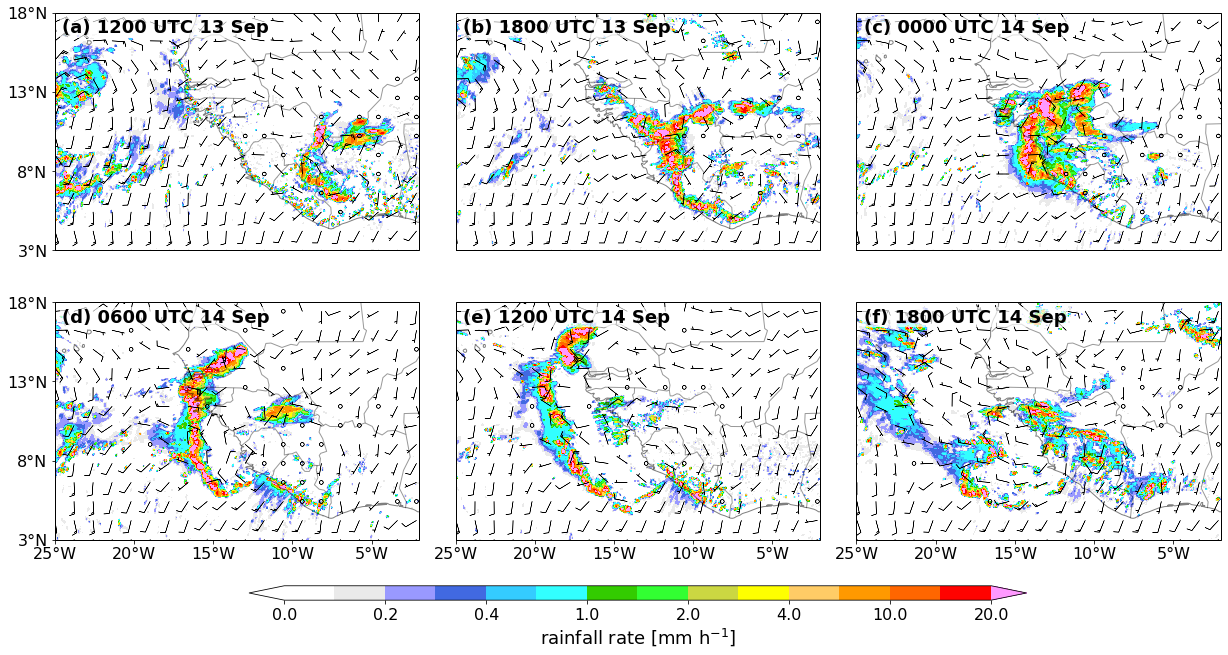

In [113]:
#define basic parameters -- placeholder; some these will come from the command line
mainDir= '/glade/scratch/rberrios/2022-real-time-forecasts/'
mpasDir= '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/'
# mpasDir='/glade/derecho/scratch/rberrios/projects/ongoing/INFORM/IOP9/'
TODAY='20220912'
HH='12'
expName='%s%s_noomld'%(TODAY,HH)

outputDir = f'{mpasDir}{expName}/intrp_output/'

#define model and related info
model='mpas'
modelInfo = 'NCAR MPAS-A'

initTime = datetime.strptime(TODAY+HH, '%Y%m%d%H')

#define image directory
# imgDir = '%s%s/%s%s/img/'%(mainDir,model,TODAY,HH)
imgDir = f'{mpasDir}{expName}/img/'
# imgDir='/glade/derecho/scratch/rberrios/projects/ongoing/INFORM/IOP9/%s%s/img/'%(TODAY,HH)

#read in variable -- also a placeholder
mainVar = 'rainr'

domain='westAfrica'

plot_6panel_maps(model, mainVar, domain, initTime)

### Compare multiple experiments

In [116]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import numpy as np
import scipy as sp

def compare_experiments_6panel(exp1_name, exp2_name, model, mainVar, domain, initTime):
    
    # --- 1. Setup Times ---
    # # Initialization: 1200 UTC 13 Sep 2022
    # init_date_str = '20220912'
    # init_hour_str = '12'
    # init_dt = datetime.strptime(init_date_str + init_hour_str, '%Y%m%d%H')
    
    # Requested Times:
    # 1. 1800 UTC 13 Sep = fhr 6
    # 2. 0000 UTC 14 Sep = fhr 12
    # 3. 0600 UTC 14 Sep = fhr 18
    forecast_hours = [6+24, 12+24, 18+24] 
    
    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

    # --- 2. Domain & Config ---
    # (Same domain logic as previous scripts)
    plotSecondVar = False
    plotWinds = False
    ms2kts = 1.94384
    landColor = 'k'
    centerLon = 0
    
    if domain == "wpac":
        minLat, maxLat = -10, 50.01
        minLon, maxLon = 80, 180.0
        lat_interval, lon_interval = 10, 15
        inc = 25
        length, lw = 3, 0.75
    elif (domain == "westAfrica"):
        minLat, maxLat = 3.0, 18.0
        minLon, maxLon = -25.0, -2.0
        lat_interval, lon_interval = 5, 5
        inc = 40 if model == 'mpas' else 5
        length, lw = 5, 2.5
        mpasStr='atl'
    # ... [Insert other domain elif blocks here] ...
    else:
        # Default
        minLat, maxLat = 10, 35
        minLon, maxLon = 110, 140
        lat_interval, lon_interval = 5, 10
        inc, length, lw = 5, 3, 1.0

    # --- 3. Setup Figure ---
    projection = ccrs.PlateCarree(central_longitude=centerLon)
    
    # 2 Rows, 3 Columns
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), 
                             subplot_kw={'projection': projection})
    
    # Zero whitespace
    fig.subplots_adjust(left=0.08, right=0.95, top=0.95, bottom=0.15, 
                        wspace=0.1, hspace=0.01)
    
    axes_flat = axes.flatten()
    last_plot_handle = None

    # --- 4. Main Loop (0 to 5) ---
    for i in range(6):
        ax = axes_flat[i]
        
        # Determine Row and Column
        row = i // 3  # 0 = Top (Exp1), 1 = Bottom (Exp2)
        col = i % 3   # 0, 1, 2 corresponding to the 3 times
        
        # Select Model and Time
        current_model = exp1_name if row == 0 else exp2_name
        label = 'NOON' if row == 0 else 'MIDNIGHT'
        outputDir = f'{mpasDir}{current_model}/intrp_output/'
        fhr = forecast_hours[col]
        
        current_dt = initTime + timedelta(hours=fhr)
        prettyDate = current_dt.strftime('%H UTC %d %b') # e.g., 1800 UTC 13 Sep

        print(f"Panel {panel_labels[i]}: {current_model} | fhr {fhr}")

        # --- Data Loading ---
        # We call the reader with 'current_model' and 'fhr'
        # (Assuming read_model_output_realtime and plottingInfo are available)
        
        # Reset flags
        plotSecondVar = False
        plotWinds = False
        
        if (mainVar == 'wspd'):
            secondVar = 'mslp'
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar, secondVar=secondVar, winds=True)
            field1 = out[mainVar]
            field2 = out[secondVar]*0.01
            uwind, vwind = out['uwind'], out['vwind']
            plotSecondVar = True
            plotWinds = True
        # ... [Insert other variable elif blocks here] ...
        elif (mainVar == 'refl10cm_1km') | (mainVar == 'rainr'):
            secondVar = '650mb_zonal_wind'
            out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar, winds=True)
            field1 = out[mainVar]
            uwind = out['uwind']*ms2kts
            vwind = out['vwind']*ms2kts
            plotWinds=True
            plotSecondVar=False
        else:
             out = read_model_output_realtime(model, TODAY, fhr, outputDir, minLat, maxLat, minLon, maxLon, mainVar)
             field1 = out[mainVar]

        # Grid setup
        lons, lats = np.meshgrid(field1.longitude, field1.latitude)

        # --- Plotting ---
        ax.set_extent([minLon, maxLon, minLat, maxLat], crs=projection)
        
        # Ticks: Only Left edge and Bottom edge
        if col == 0:
            ax.set_yticks(np.arange(minLat, maxLat+0.1, lat_interval), crs=projection)
            ax.yaxis.set_major_formatter(LatitudeFormatter())
            
            # Add ROW LABEL (Experiment Name) on the far left
            # We use axes coordinates. x=-0.25 puts it to the left of the y-axis ticks
            ax.text(-0.25, 0.5, label, transform=ax.transAxes, 
                    rotation=90, va='center', ha='center', fontsize=14, fontweight='bold')
        else:
            ax.set_yticks([])
            
        if row == 1:
            ax.set_xticks(np.arange(minLon, maxLon+0.1, lon_interval), crs=projection)
            ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
        else:
            ax.set_xticks([])

        # Features
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), alpha=0.5, edgecolor=landColor)
        ax.add_feature(cfeature.BORDERS, alpha=0.4, edgecolor=landColor)

        # Contours
        cnLevels = plottingInfo[mainVar]['levels']
        cmap = plottingInfo[mainVar]['cmap']
        
        if ('acpc' in mainVar) | (mainVar == 'rainr') | ('vorticity' in mainVar):
            norm = mcolors.BoundaryNorm(boundaries=cnLevels, ncolors=len(cnLevels)-1)
            plotCnt = ax.contourf(lons, lats, field1, transform=projection, levels=cnLevels, extend='both', cmap=cmap, norm=norm)
        else:
            plotCnt = ax.contourf(lons, lats, field1, transform=projection, levels=cnLevels, extend='both', cmap=cmap)
            
        last_plot_handle = plotCnt

        # Second Var & Winds
        if plotSecondVar:
            field2_smooth = sp.ndimage.filters.gaussian_filter(field2, 2.0)
            cnLevels2 = plottingInfo[secondVar]['levels']
            plotCntLines = ax.contour(lons, lats, field2_smooth, transform=projection, colors='k', levels=cnLevels2, linewidths=lw)
            ax.clabel(plotCntLines, inline=1, fontsize=6, fmt=plottingInfo[secondVar]['fmt'])

        if plotWinds:
            sl = slice(None, None, inc)
            if (mainVar == 'wspd') | (mainVar == 'ivt'):
                ax.quiver(lons[sl, sl], lats[sl, sl], uwind[sl, sl], vwind[sl, sl], transform=projection)
            else:
                ax.barbs(lons[sl, sl], lats[sl, sl], uwind[sl, sl], vwind[sl, sl], length=length, lw=0.5, transform=projection)

        # --- Internal Labels ---
        # Panel Letter + Date
        ax.text(0.02, 0.975, f"{panel_labels[i]} {prettyDate}", 
                transform=ax.transAxes, fontsize=18, fontweight='bold', va='top',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1.5))

    # --- 5. Manual Colorbar ---
    # Located at bottom, thin profile
    cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.02]) 
    cbar = fig.colorbar(last_plot_handle, cax=cbar_ax, orientation='horizontal')
    cbar.ax.set_xlabel(f"{plottingInfo[mainVar]['longName']} [{plottingInfo[mainVar]['units']}]", fontsize=18)

    # --- 6. Save ---
    fout = f"comparison_{exp1_name}_vs_{exp2_name}_{mainVar}_{domain}.jpg"
    plt.savefig(fout, bbox_inches='tight', dpi=200)
    # plt.close()
    print(f'Created comparison plot: {fout}')

# Example Usage:
# compare_experiments_6panel('Control_Exp', 'New_Physics_Exp', 'wspd', 'wpac')

Panel (a): 2022091212_noomld_perpnoon | fhr 30
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_18:00_latlon_westAfrica.nc
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_17:00_latlon_westAfrica.nc
Panel (b): 2022091212_noomld_perpnoon | fhr 36
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-14_00:00_latlon_westAfrica.nc
/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/2022091212_noomld_perpnoon/intrp_output/mpas_init_2022091212_valid_2022-09-13_23:00_latlon_westAfrica.nc
Panel (c): 2022091212_noomld_perpnoon | fhr 42
/glade/derecho/

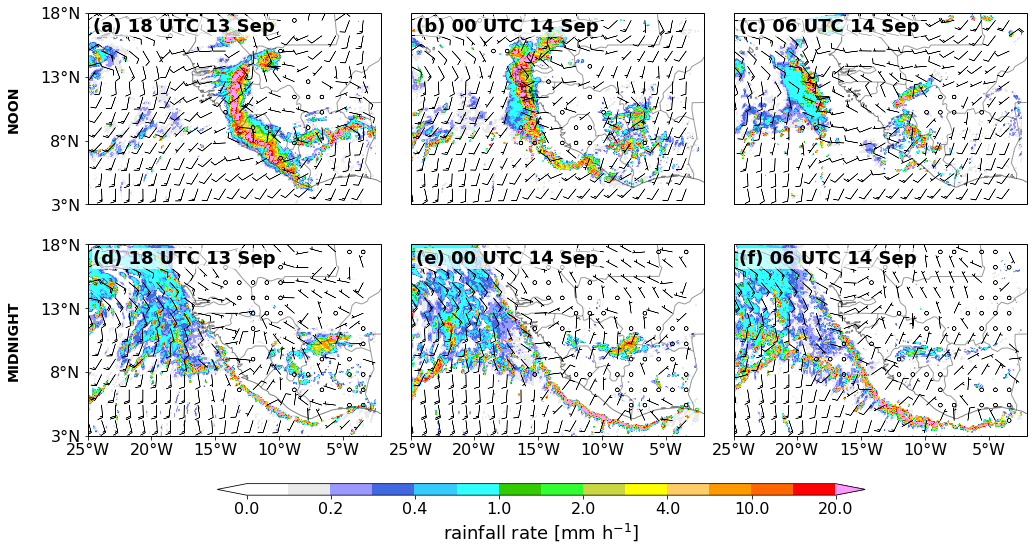

In [117]:
exp1_name='2022091212_noomld_perpnoon'
exp2_name='2022091212_noomld_perpmidnight'

compare_experiments_6panel(exp1_name, exp2_name, model, mainVar, domain, initTime)